In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
import tushare as ts
from sklearn import preprocessing
from sklearn import metrics

In [2]:
# 获取tushare数据
cons=ts.get_apis()
def get_data(start_date='2005-01-01',end_date=''):
    all_data = ts.bar('000300', conn=cons, asset='INDEX', start_date=start_date, end_date=end_date)
    all_data=all_data.dropna()
    all_data=all_data[::-1]
    return all_data

train_dataframe = get_data(start_date='2005-01-01',end_date='2014-12-31')
test_dataframe = get_data(start_date='2015-01-01',end_date='2020-05-10')
test_dataframe.head()

,code,open,close,high,low,vol,amount,p_change
datetime,,,,,,,,
2015-01-06,000300,3608.43,3641.06,3683.23,3587.23,4209621.0,4.985296e+11,-0.01
2015-01-07,000300,3620.92,3643.79,3671.19,3601.70,3201912.0,3.987317e+11,0.07
2015-01-08,000300,3650.07,3559.26,3659.94,3552.10,2950030.0,3.558320e+11,-2.32
2015-01-09,000300,3547.57,3546.72,3689.75,3536.40,3499826.0,4.302106e+11,-0.35
2015-01-12,000300,3531.51,3513.58,3560.53,3461.32,2665671.0,3.342571e+11,-0.93


In [3]:
name_dict = {name:index for index,name in enumerate(train_dataframe.columns.tolist()[1:7])}
name_dict_inv = {index:name for index,name in enumerate(train_dataframe.columns.tolist()[1:7])}
print(name_dict)
print(name_dict_inv)

{'open': 0, 'close': 1, 'high': 2, 'low': 3, 'vol': 4, 'amount': 5}
{0: 'open', 1: 'close', 2: 'high', 3: 'low', 4: 'vol', 5: 'amount'}


In [4]:
def wavelet_reconstruct(data,wavelet,threshold):
    # 选用小波
    w = pywt.Wavelet(wavelet) 
    maxlev = pywt.dwt_max_level(len(data),w.dec_len)
    coeffs = pywt.wavedec(data,wavelet,level=maxlev)

    # 将噪声滤波
    for i in range(1,len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i],threshold*max(coeffs[i]))
    
    # 重建数据
    data_rec = pywt.waverec(coeffs,wavelet)
    
    return data_rec

def compare_plot(data_source,data_rec):
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot([i for i in range(len(data_source))],data_source)
    plt.title('Raw Signal')
    
    plt.subplot(2, 1, 2)
    plt.plot([i for i in range(len(data_rec))],data_rec)
    plt.title('De-noised signal')
    
    plt.tight_layout()
    plt.show()
         
# Example  
# open_value = data['open'].astype('float32')
# open_value_rec = wavelet_reconstruct(open_value,'db8',0.1)
# compare_plot(open_value,open_value_rec)

In [5]:
def construct_data(dataframe,wavelet,threshold,is_wavelet=False):
    if is_wavelet:
        all_data = []
        for name in name_dict.keys():
            data = dataframe[name].astype('float32')
            data_rec = wavelet_reconstruct(data,wavelet,threshold)
            all_data.append(data_rec)
        all_data = np.array(all_data).T
    else:
        all_data = [dataframe[name].astype('float32') for name in name_dict.keys()]
        all_data = np.array(all_data).T
    return all_data

train_data = construct_data(train_dataframe,wavelet='db8',threshold=0.1,is_wavelet=False)
test_data = construct_data(test_dataframe,wavelet='db8',threshold=0.1,is_wavelet=False)
print(train_data.shape)
print(test_data.shape)

(2426, 6)
(1300, 6)


In [6]:
# MinMax归一化
def min_max_norm(data):
    data_max = np.max(data,axis=0)
    data_min = np.min(data,axis=0)
    data = (data-data_min)/(data_max-data_min)
    return data,data_max,data_min

all_scaled_data,all_max,all_min = min_max_norm(np.concatenate([train_data,test_data],axis=0))

train_scaled_data = all_scaled_data[:len(train_data),:]
test_scaled_data = all_scaled_data[len(train_data):,:]
print(train_data.shape,test_data.shape)
print(train_scaled_data.shape,test_scaled_data.shape,all_scaled_data.shape)

(2426, 6) (1300, 6)
(2426, 6) (1300, 6) (3726, 6)


In [7]:
# 切割的独立矩阵块大小，通常以windows-1日作为训练矩阵块，最后一日为真实矩阵块，用于验证预测答案
def divide_data(data,window_size):
    # 类似于卷积，这里设置步长为1
    n_items = data.shape[0] - window_size + 1
    # 最后分割好的独立矩阵块
    final_items = np.zeros([n_items,window_size,data.shape[1]])
    for index_item in range(n_items):
        matrix = data[index_item:index_item + window_size,:].copy()
        final_items[index_item,:,:] = matrix
    return final_items

window_size = 11
train_group_scaled_data = divide_data(train_scaled_data,window_size)
test_group_scaled_data = divide_data(test_scaled_data,window_size)

print("train group data shape =",train_group_scaled_data.shape)
print("test group data shape =",test_group_scaled_data.shape)

# 确定最后的输入形式
x_train = train_group_scaled_data[:,:-1,:] # (train_length,10,6),data
y_train = train_group_scaled_data[:,-1,:]  # (train_length,1,6) = (train_length,6),label
x_test = test_group_scaled_data[:,:-1,:]   # (test_length,10,6),data
y_test = test_group_scaled_data[:,-1,:]    # (test_length,1,6) = (test_length,6),label
print("x_train shape =",x_train.shape)
print("y_train shape =",y_train.shape)
print("x_test shape =",x_test.shape)
print("y_test shape =",y_test.shape)

train group data shape = (2416, 11, 6)
test group data shape = (1290, 11, 6)
x_train shape = (2416, 10, 6)
y_train shape = (2416, 6)
x_test shape = (1290, 10, 6)
y_test shape = (1290, 6)


In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,CuDNNLSTM,LeakyReLU
from keras.callbacks import EarlyStopping
import keras.backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def Theil_error(y_true,y_pred):
    K1 = K.sqrt(K.mean(K.square(y_pred-y_true)))
    K2 = K.sqrt(K.mean(K.square(y_pred)))
    K3 = K.sqrt(K.mean(K.square(y_true)))
    return K1 / (K2 + K3)

# 单个模型
model = Sequential()
model.add(CuDNNLSTM(64,input_shape=(x_train.shape[1],x_train.shape[2]),return_sequences=True))
model.add(CuDNNLSTM(32,return_sequences=False))
model.add(Dense(16,kernel_initializer='uniform'))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(x_train.shape[2],kernel_initializer='uniform'))
model.add(LeakyReLU(alpha=0.2))
model.compile(loss=rmse,optimizer='adam')
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2)
model.fit(x_train,y_train,epochs=500,batch_size=128,validation_split=0.1,verbose=1,shuffle=True,callbacks=[early_stopping])
y_pred = model.predict(x_test)
for name,index in name_dict.items():
    print(name + " R Square =",metrics.r2_score(y_test[:,index],y_pred[:,index]))
    print(name + " RMSE =",metrics.mean_squared_error(y_test[:,index],y_pred[:,index])** 0.5)
    print(name + " MAE =",metrics.mean_absolute_error(y_test[:,index],y_pred[:,index]))
    print()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 10, 64)            18432     
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 32)                12544     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6)                 0         
Total params: 31,606
Trainable params: 31,606
Non-trainable params: 0


2174/2174 [==============================] - 0s 88us/step - loss: 0.0126 - val_loss: 0.0294
Epoch 140/500
2174/2174 [==============================] - 0s 89us/step - loss: 0.0124 - val_loss: 0.0299
Epoch 141/500
2174/2174 [==============================] - 0s 89us/step - loss: 0.0125 - val_loss: 0.0311
Epoch 142/500
2174/2174 [==============================] - 0s 87us/step - loss: 0.0130 - val_loss: 0.0302
Epoch 143/500
2174/2174 [==============================] - 0s 90us/step - loss: 0.0130 - val_loss: 0.0295
Epoch 144/500
2174/2174 [==============================] - 0s 87us/step - loss: 0.0126 - val_loss: 0.0296
Epoch 145/500
2174/2174 [==============================] - 0s 89us/step - loss: 0.0126 - val_loss: 0.0300
Epoch 146/500
2174/2174 [==============================] - 0s 87us/step - loss: 0.0125 - val_loss: 0.0300
Epoch 147/500
2174/2174 [==============================] - 0s 86us/step - loss: 0.0124 - val_loss: 0.0293
Epoch 148/500
2174/2174 [==============================] - 0

In [9]:
# 归一化反变换，用于将神经网络预测的数据重新变成可读的形式
y_test_unscaled = y_test * (all_max-all_min) + all_min
y_pred_unscaled = y_pred * (all_max-all_min) + all_min

In [10]:
# 画图
def plot_picture(y_test,y_pred,draw_item='close'):
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(style='ticks')
    plt.figure(dpi=600)
    
    # 选一项进行画图
    select_number = name_dict[draw_item]

    # 画图
    draw_dataframe = pd.DataFrame({'predict_value':y_pred_unscaled[:,select_number],'true_value':y_test_unscaled[:,select_number]})
    p = sns.lineplot(data=draw_dataframe,dashes = False)

    # 设置图表标题
    p.set_xlabel('days')
    p.set_ylabel(name_dict_inv[select_number] + ' value')

    # 给橙色线设置透明度，用于辨识重合的部分
    plt.setp([p.get_children()[1]],alpha=0.8)
    plt.show()

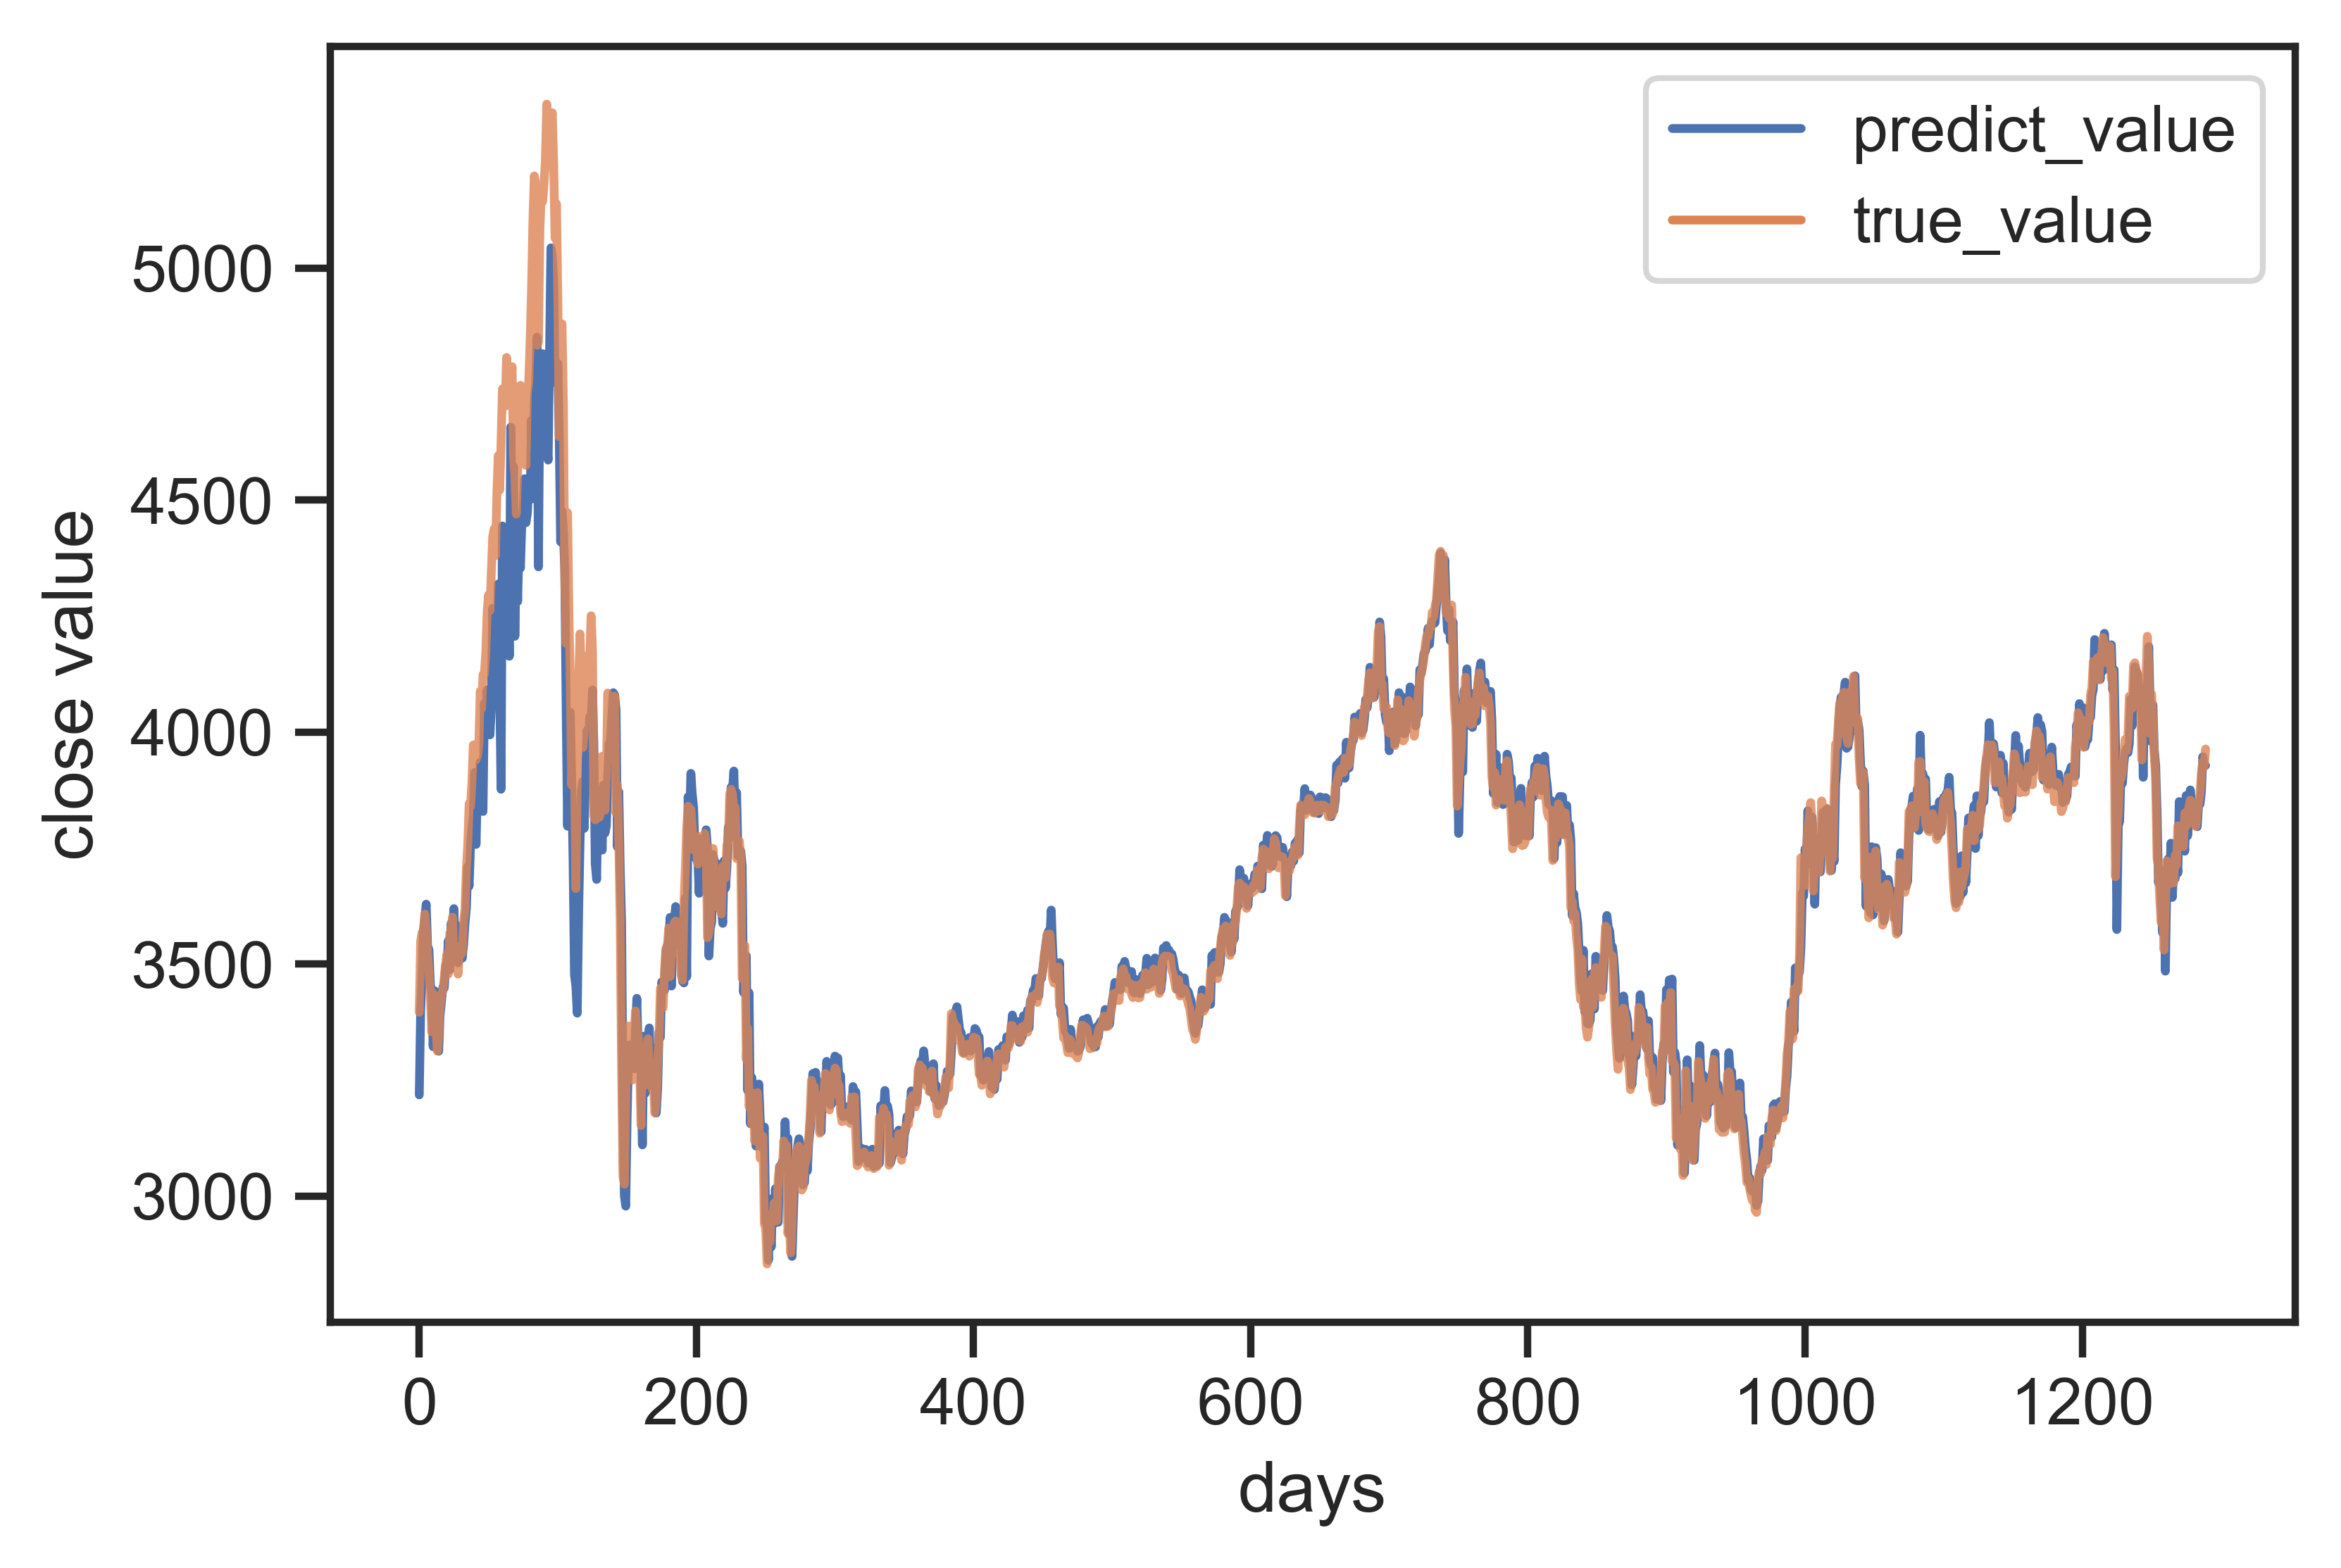

In [11]:
plot_picture(y_test_unscaled,y_pred_unscaled,draw_item='close')